In [1]:
from dotenv import load_dotenv
load_dotenv()  

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

RAG : vector store + web 검색 (Tavily)

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [6]:
from langchain_classic import hub
from langchain_core.callbacks import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")

generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:

    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}

In [7]:
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain_classic import hub
from typing import Literal
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelvant']:

    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'relevant'
    
    return 'irrelvant'

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template("""사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요
질문: {query}
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})

    return {'query': response}

In [9]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    query = state['query']
    results = tavily_search_tool.invoke(query)
    return {'context': results}

/var/folders/rb/wylmzgk90lb3vbd81tm_qck00000gn/T/ipykernel_29614/3989946988.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
# graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

서비스 관점에서 굳이 rewrite는 필요 없다. 

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelvant': 'web_search'
    }
)
# graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [12]:
graph = graph_builder.compile()

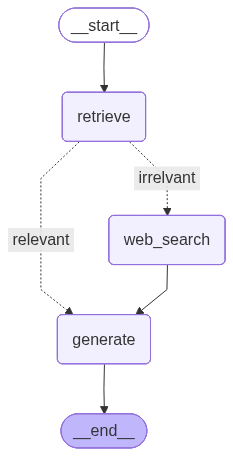

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [{'title': '연봉 5000만원에 대한 소득세가 다르게 계산되는 문제 - 인프런',
   'url': 'https://www.inflearn.com/community/questions/1653610/%EC%97%B0%EB%B4%89-5000%EB%A7%8C%EC%9B%90%EC%97%90-%EB%8C%80%ED%95%9C-%EC%86%8C%EB%93%9D%EC%84%B8%EA%B0%80-%EB%8B%A4%EB%A5%B4%EA%B2%8C-%EA%B3%84%EC%82%B0%EB%90%98%EB%8A%94-%EB%AC%B8%EC%A0%9C?srsltid=AfmBOooAfbOP5-hYqqrkwZemw_zOG6XXCc3pmlmLNGkJrdqxEJ58tN-H',
   'content': '4강까지 강의를 다 들었습니다.  \n하지만 연봉 5천만원인 거주자의 소득세는? 이라는 쿼리를 날릴경우 답변이 624만원이 나오지 않고 다양한 값이 나오고 있는것을 확인했습니다.  \n  \nupstage model을 사용하고 pinecone vector store 를 사용하고 있으며 dictionary chain 까지 구성해서 직장인 -> 거주자로 바꾸는것 까지 적용해서 invoke 를 실행했습니다.  \n  \n직접 테스트한 예시로는   \n\'query\': 연봉 5천만원인 거주자의 소득세는 얼마인가요? 소득구간별 세율의 예시를 보여주면서 설명해줘,  \n\'result\': \'연봉 5천만원인 직장인의 소득세는 550만원입니다. 소득구간별 세율에 따라 계산하면, 5천만원 이하의 과세표준에는 15%의 세율이 적용되어 84만원 + (1,400만원을 초과하는 금액의 15%) = 550만원이 소득세로 산출됩니다.\'},  \n  \n{\'query\': \'연봉 5천만원인 직장인의 소득세는 얼마인가요?\', \'result\': \'연봉 5천만원인 직장인의 소득세는 550만원입니다. 이는 종

In [15]:
initial_state = {'query': '역삼역 맛집을 추천해주세요'}
graph.invoke(initial_state)

{'query': '역삼역 맛집을 추천해주세요',
 'context': [{'title': '역삼역 주변 맛집 리스트 - pangpang - 티스토리',
   'url': 'https://sam-repository.tistory.com/11',
   'content': "## 10. 신동궁감자탕 역삼직영점\n\n키워드: #한식 #뼈숯불구이 #감자탕 #양배추샐러드도맛도리 #많이매운편 #볶음밥도필수  \n도로명주소: 서울 강남구 테헤란로10길 21 1층  \n맛있게 먹은 사람: 73.77% (987 / 1338)  \n한 줄 평가:매운 음식을 좋아한다면 도전해볼만한 뼈숯불구이!  \n   \n매운 음식을 좋아한다면 신동궁감자탕 역삼직영점에서 매운 뼈숯불구이를 도전해보시는 건 어떨까요? 꽤 매운 편이라서 호불호가 갈릴 수 있으니 꼭! 매운 음식을 좋아하는 사람들이랑 가는 것을 추천드려요. 등뼈 사이사이에 낀 살이 부드럽게 발라지고, 중간중간 양배추 샐러드를 곁들여 먹거나 밥이랑 비벼 먹어도 좋아요. 다만 6시를 기준으로 사람들이 물밀 듯이 갈 수 있으니 웨이팅을 해야 할 수도 있습니다.\n\n이상으로 역삼역 주변 맛집 리스트를 정리해보았는데요, 이번 글을 읽고 역삼역 인근의 맛집을 찾는데 도움이 되셨으면 좋겠습니다! 이상 읽어주셔서 감사합니다. 😁😁\n\n#### 'SSAFY > SSAFYcial' 카테고리의 다른 글 [...] 본문 바로가기\n\n# pangpang\n\nPOWERED BY TISTORY\n\nSSAFY/SSAFYcial\n\n# 역삼역 주변 맛집 리스트\n\npangpang\\_i 2023. 11. 19. 21:02\n\n바로가기 목록\n\n 1. 칼국수 집이지만 감자전이 진짜 맛있는, 선덕칼국수\n 2. 가성비 좋은 최상급 이베리코, 하몽하몽이베리코\n 3. 멀리서 찾아와서도 먹는 닭볶음탕 찐맛집, 고갯마루\n 4. 맑은 국물이 땅긴다, 이도곰탕\n 5. 쫄깃한 화덕피자 도우가 일품인, 지아니스나폴리\n 6. 매운치즈갈비찜이 진리, 갈비다움\n